In [1]:
# Modules and data loading
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import  Polygon
from mpl_toolkits.basemap import Basemap as Basemap

import sys
sys.path.append('..')
from pickle_fns import *
import math
from scipy.interpolate import griddata,interp2d
from scipy import spatial
from numpy import ones,vstack
from numpy.linalg import lstsq


In [2]:
def get_polysFromLayers_mod(elevation,layers,xycoords,xi,yi):
    polys=[]

    ztbs=[]
    depth_on_cl=[]
    indeces=[]
    fyi=np.flipud(yi)
    fxi=np.flipud(xi)
    for xyind in xycoords[:,:]:
#         print(j,end=',')
        indx,indy=np.where(xi==xyind[0])[0],np.where(yi==xyind[1])[0]
        indeces.append([indx,indy])
        depth_on_cl.append(elevation[indy,indx][0])
    depth_on_cl=np.array([depth_on_cl])
#     print(depth_on_cl)
    for i in range(len(layers)):
#         print(i)
        j=0
        thk_on_cl=[]
        for xyind in indeces:
    #         print(j,end=',')
#             indx,indy=np.where(xi==xyind[0])[0],np.where(yi==xyind[1])[0]
            thk_on_cl.append(layers[i][xyind[1],xyind[0]][0])
            j +=1
        #     print(indx,indy)
        depth_on_cl=np.append(depth_on_cl,[depth_on_cl[-1]+thk_on_cl],axis=0)

    polygons=[]
    for i in range(1,len(depth_on_cl)):
    #     poly=[xycoords depth_on_cl
        xyz_top=np.append(xycoords.T,[depth_on_cl[i-1]],axis=0)
        xyz_bot=np.append(xycoords.T,[depth_on_cl[i]],axis=0)
        polygons.append(np.append(xyz_top.T,np.flipud(xyz_bot.T),axis=0))    
    return polygons,depth_on_cl
def crook_triangle(loc,dist=0.005):
    return [[loc[0]-dist,loc[1]-dist],
     [loc[0]+dist,loc[1]-dist],
     [loc[0]+dist,loc[1]],
     [loc[0]-dist,loc[1]-dist],
    ]
def gety(x,points):
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
#     print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    return m*x+c
def get_indx_of_croockedline(coords,crooked_line):
    myKDTree = spatial.KDTree(coords)
    final_x=[]
    final_y=[]
    for i in range(1,len(crooked_line)):
        point_pair=np.array([crooked_line[i],crooked_line[i-1]])
        print('point_pair: ',point_pair[:,0])

    #     
        sel_xi=xi[xi>=min(point_pair[:,0]) ]
        sel_xi=sel_xi[sel_xi<=max(point_pair[:,0])+sel_xi[1]-sel_xi[0]]
    #     break
        final_x.extend(sel_xi)
        final_y.extend(gety(sel_xi,point_pair))


    #get close_y index
    IND=[]
    for pt in zip(final_x,final_y):
        distance,index=myKDTree.query(pt)
        IND.append(index)
    return IND
def get_indx_of_croockedline_mod(coords,crooked_line):
    myKDTree = spatial.KDTree(coords)
#     _,index0=myKDTree.query((sel_xi[0],sel_yi[0]))
    final_x=[]
    final_y=[]
    IND=[]
    for i in range(1,len(crooked_line)):
        point_pair=np.array([crooked_line[i],crooked_line[i-1]])
#         print('point_pair: ',point_pair[:,0])

    #     
        sel_xi=xi[xi>=min(point_pair[:,0]) ]
        sel_xi=sel_xi[sel_xi<=max(point_pair[:,0])+sel_xi[1]-sel_xi[0]]
    #     break
        final_x.extend(sel_xi)
        sel_yi=gety(sel_xi,point_pair)
        final_y.extend(sel_yi)
        [sel_xi[0],sel_xi[-1]]
        _,index0=myKDTree.query((sel_xi[0],sel_yi[0]))
        _,index1=myKDTree.query((sel_xi[-1],sel_yi[-1]))
#         interval=int(round((index1-index0)/(len(sel_xi)-1)))
#         ind=list(range(index0,index1+1,interval))
        ind=np.int32(np.linspace(index0, index1, len(sel_xi), endpoint=True))
#         diff=index1-ind[-1]
        
#         corr_fact=diff/len(sel_xi)
#         corr_vect=np.round(np.arange(len(sel_xi))*corr_fact)
#         print('diff :{} , corr.fact: {}'.format(diff,corr_fact))
#         print(corr_vect)
        IND.extend(ind)
#         IND.extend()


    #get close_y index
    
#     for pt in zip(final_x,final_y):
#         distance,index=myKDTree.query(pt)
#         IND.append(index)
    return IND
def design_crooked_section(loc_array,vesdf):
    loc_coords=[]
    for loc in loc_array:
        loc_coords.append(vesdf[vesdf['VES No.']==str(loc)][['Easting','Northing']].values.astype(float))
  
    return np.array(loc_coords).ravel().reshape(len(loc_array),2)
def design_crooked_section_w_ele(loc_array,vesdf):
    loc_coords=[]
    for loc in loc_array:
        loc_coords.append(vesdf[vesdf['VES No.']==str(loc)][['Easting','Northing','RL']].values.astype(float))
  
    return np.array(loc_coords).ravel().reshape(len(loc_array),3)
def get_sections():
    profiles=load_pkl(base_folder+'profiles.pkl')
    sections=[]
    for profile in profiles:
        sections.append([p[0] for p in profile])
    return sections   

def iwd(x,y,v,gridsize=(100,100),power=2):
    xi = np.linspace(min(x),max(x),gridsize[0])
    yi = np.linspace(min(y),max(y),gridsize[1])
    grid = np.zeros((len(xi),len(yi)))
    for ix,i in enumerate(xi):
        for jy,j in enumerate(yi):
            distance = np.sqrt((x-i)**2+(y-j)**2)
            if (distance**power).min()==0: 
                grid[ix,jy] = v[(distance**power).argmin()]
            else:
                total = np.sum(1/(distance**power))
                grid[ix,jy] = np.sum(v/(distance**power)/total)
    return grid.T


def calc_plot_grid(P,gridsize=(100,100),method='kriging',power=2):    
    xi = np.linspace(min(P[:,0]),max(P[:,0]),gridsize[0])
    yi = np.linspace(min(P[:,1]),max(P[:,1]),gridsize[1])
    fig=plt.figure(figsize=(10,10))
    # grid the data.
    if method=='cubic':
        zi = griddata((P[:,0], P[:,1]), P[:,2], (xi[None,:], yi[:,None]), method='cubic')
    elif method=='kriging':
        zi = np.zeros((len(xi),len(yi)))
        sill=1200
        arange=390
        covfct = model.covariance( model.gaussian, ( arange, sill ) )
        for i,x in enumerate(xi):
            for j,y in enumerate(yi):
                zi[i,j]=kriging.simple( P, covfct,(x,y), N=16)[0]
    elif method=='iwd':
        zi=iwd(P[:,0], P[:,1], P[:,2],gridsize,power=power)
    CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
    plt.colorbar() # draw colorbar
    # plot data points.
    plt.scatter(P[:,0], P[:,1],marker='o',c='b',s=5)
    for p in P:
        plt.annotate(str(int(p[2])),xy=(p[0],p[1]))
#     plt.show()


# from mpl_toolkits.axes_grid.anchored_artists import AnchoredDrawingArea
# from matplotlib.patches import Circle



def find_closeDlocsIdx(sec_coords,dcoords,dist_thresh=1):
    myKDTree = spatial.KDTree(dcoords)
    close_loc_idx=[]
    for sc in sec_coords:            
        dist,indx=myKDTree.query(sc)
#         print(dist*104)
        if dist*104<dist_thresh:
            close_loc_idx.append(indx)
    return close_loc_idx
def get_loc_polygons(idxs,final_depths,width):
    polygons=[]
    for idx in idxs:
        xi,yi=[final_depths[idx,0]-width/2,final_depths[idx,0]+width/2], [final_depths[idx,1]-width/2,final_depths[idx,1]+width/2]
        depth_on_cl=[]
        for i in range(2,final_depths.shape[1]): # Here 
    #             print(i)

            zi=[]
            for x,y in zip(xi,yi):
                zi.append( final_depths[idx,i])
    #             print(zi)
            depth_on_cl.append(zi)
#         print(depth_on_cl)
        sectionpart=[]
        xycoords=[[x,y] for x,y in zip(xi,yi)]
        xycoords=np.array(xycoords)
        for i in range(1,len(depth_on_cl)):
            xyz_top=np.append(xycoords.T,[depth_on_cl[i-1]],axis=0)
            xyz_bot=np.append(xycoords.T,[depth_on_cl[i]],axis=0)
            sectionpart.append(np.append(xyz_top.T,np.flipud(xyz_bot.T),axis=0))  
    #             xyz=[[x,y,z] for x,y,z in zip(xi,yi,zi)]
#         print(xyz_top)
        polygons.append(sectionpart)
    return polygons
def get_drill_loc_polys(section,vesdf,dvesdf,dfinal_depths,dist_thresh=1):
    loc_coords=[]
    for loc in section:
        loc_coords.append(vesdf[vesdf['VES No.']==str(loc)][['Easting','Northing']].values.astype(float))
    sec_coords=np.array( loc_coords)
    sec_coords.shape=sec_coords.shape[0],sec_coords.shape[-1]
#     plt.plot(sec_coords[:,0],sec_coords[:,1])

    dE,dN,dEle=dvesdf.Easting.values.astype(np.float),dvesdf.Northing.values.astype(np.float),dvesdf.RL.values.astype(np.float)
#     plt.plot(dE,dN,'.r')
    dcoords=[[e,n] for e,n in zip(dE,dN)]

    didxs=find_closeDlocsIdx(sec_coords,dcoords,dist_thresh)   
    # for idx in didxs:
    loc_polys=get_loc_polygons(didxs,dfinal_depths,0.01)
    loc_names=vesdf['Location'].values[didxs]
    return loc_polys,loc_names


def legned(ax,final_lbls,facies_colors,lith_dict_summay,ystart_loc=0.9,yinc=0.1):   
    ufinal_lbls=np.unique(final_lbls)
    ty=ystart_loc-0.2
    ax.text(0.70, ystart_loc, 'LEGEND', transform=ax.transAxes, fontsize=15,
        verticalalignment='top')
    for i in ufinal_lbls:       
        # textstr='R: '+str(int(rs[i]))+'- '+ls[i]+': '+str(ls[i])
        blank_str='___'
        textstr = lith_dict_summay[i]
#             idx=llb[i] if llb[i]<10 else llb[i]/10
        props = dict(boxstyle='round', facecolor=facies_colors[i], alpha=1) #-0.6/nlocs
    
        ax.text(0.70, ty, blank_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
       
        ax.text(0.72, ty, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
        ty -=yinc
    ax.text(0.70, ty, '___ ', transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
       
    ax.text(0.72, ty, 'Possible Fractures', transform=ax.transAxes, fontsize=10,
        verticalalignment='top')
# normal_proj=True
# patches=[]
# for total_section,section,image_name in zip(polysets[n:n+1],sections[n:n+1],sec_image_names[n:n+1]):

def plot_location_map(plt,crooked_line,sec_lbl):
    boundaries=load_pkl(base_folder+'boundaries.pkl')
    (w,h)=4*len(section),10
    yw=0.2
#     xw=2*yw*h/w
    xw=0.15
    a = plt.axes([.2, .15, xw*1.5, yw], facecolor='grey')


    a.patch.set_alpha(0.5)
    a.plot(E, N, 'b.') #brush=pg.mkBrush(255, 100, 255, 120),pen=None,
    #district and block boundaries
    if len(boundaries)>0:
        for b in boundaries:
            # a.plot(b)
            a.plot([g for g in b[0]], [g for g in b[1]],'k')

        profile=[]
#         for _,b in self.profiles[list_w.currentRow()-1]:

        a.plot(crooked_line[:,0], crooked_line[:,1],'-r')
        # a.annotate('L', xy=(profile[0,0]-0.02, profile[0,1]-0.02))
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
        a.text(crooked_line[0,0]-0.02, crooked_line[0,1]-0.02,sec_lbl.upper(), ha="center", va="center", size=10,
                bbox=bbox_props)
        a.text(crooked_line[-1,0], crooked_line[-1,1], sec_lbl.upper()+'\'', ha="center", va="center", size=10,
                bbox=bbox_props)
    return plt

In [3]:
# import inspect
# print(inspect.getsource(find_closeDlocsIdx))

# print(inspect.getsource(get_drill_loc_polys))

In [4]:
# This is with gridding method of inverse power distance
#         print(crooked_line)



#             xyzcoords.append(xyz)
#             break
#     polysets.append(polygons)
#         print(xi,yi)
#     break
# xyzcoords
# depth_on_cl
nsections=10
polysets=[]
for section,sec_name in zip(sections[:nsections],profile_name[:nsections]):
#     if i==1:
    print(section,sec_name)
    crooked_line=design_crooked_section(section,vesdf)
    polygons=get_line_polygons_frac_curves(crooked_line,final_depths)
    polysets.append(polygons)
np.save(base_folder+'polysets.npy',polysets)

NameError: name 'sections' is not defined

In [369]:
# fracdf

In [5]:
def get_fracdata(newdf,drange=(0,30)):
    return newdf[ (newdf.Fracture1>drange[0]) & (newdf.Fracture1<=drange[1])]
#VES fracture data
def get_section_frac_curve(xi,yi,drange=(0,30),iwd_power=6):
    findlimit=0.999
    fdata=get_fracdata(fracdf,drange=drange).values
    findicator=np.append(fdf[['Easting','Northing']].values,np.zeros((len(fdf['VES NO']),1)),axis=1)
    for i,f in enumerate(fdf['VES NO'].values):
        if f in fdata[:,0]:
            findicator[i,2]=1    
    zi=[]
    for x,y in zip(xi,yi):
        if iwd_point(findicator[:,0], findicator[:,1], findicator[:,2],(x,y),power=iwd_power)>findlimit:
            zi.append(iwd_point(fdata[:,1], fdata[:,2], fdata[:,3],(x,y),power=iwd_power))
        else:
            zi.append(np.nan)
    return np.array(zi)




# franges=[(0,30),(30,60),(60,90),(90,200)]




# nsections=1
# for section,sec_name in zip(sections[:nsections],profile_name[:nsections]):
# #     if i==1:
#     print(section,sec_name)
#     crooked_line=design_crooked_section(section,vesdf)
    
#     for ic in range(1,len(crooked_line)):
#         crookpart=np.append([crooked_line[ic-1]],[crooked_line[ic]],axis=0)
#         xi=np.linspace(crookpart[0][0],crookpart[1][0],50)            
#         yi=gety(xi,crookpart)

# get_section_frac_curve(xi,yi,drange=(0,30),iwd_power=6).shape

In [6]:
# a=np.array([2,3])
# b=np.array([1,2])
# # a+np.array(b)
# a-1
a=np.random.random(10)

av=moving_average(a,n=3)
aw=window_average(a,n=5)

plt.plot(a)
plt.plot(av)
plt.plot(aw,'r')
n=3
# list(range(n-round((n-1)/2),n+round((n-1)/2)))

NameError: name 'moving_average' is not defined

In [7]:
def window_average(arr, n=3) :
#     orarr=arr.copy()
    lenarr=len(arr)
    nedge=round((n-1)/2)
    arr=np.append(np.append(arr[:nedge],arr),arr[-nedge:])
#     print('len of arr',len(arr))

    resarr=arr[:lenarr].copy()
#     print(len(resarr))
    for i in range(1,n):
#         print(len(arr[i:lenarr+i]))
#         print(resarr)
        resarr +=arr[i:lenarr+i].copy()
#     print(resarr/n)
    return resarr/n

        
def iwd_point(x,y,v,xy,power=2):
    n_nearest=3
    distance = np.sqrt((x-xy[0])**2+(y-xy[1])**2)+0.000001
    b=np.argsort(distance)
    distance=distance[b[:n_nearest]]
    v=v[b[:n_nearest]]
#     print(len(distance),end=', ')
#     if distance**power==0: 
#         est = v[(distance**power).argmin()]
#     else:
    total = np.sum(1/(distance**power))
    est = np.sum(v/(distance**power))/total
    return est

def polyclose_point(x,y,z,xy,order=2):
    n_nearest=3
    distance = np.sqrt((x-xy[0])**2+(y-xy[1])**2)+0.000001
    b=np.argsort(distance)
    idxs=b[:n_nearest]
    distance=distance[idxs]
    x,y,z=x[idxs],y[idxs],z[idxs]
    m = polyfit2d(x,y,z,order=order)
    return polyval2d(xy[0],xy[1], m)
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z
def add_2dpolygons(ax,polysets,normal_proj,facies_colors,correction=0):
    for polygons in polysets:
        for k in range(len(polygons)):
            if len(polygons[k])>0:
                x=np.array(polygons[k][:,0])
                y=np.array(polygons[k][:,1])
                z=np.array(polygons[k][:,2])
                if normal_proj:
                    polygon = Polygon(np.array([x+correction,z]).T, closed=True,facecolor=facies_colors[final_lbls[k]],
                              edgecolor='gray',fill=True,)
                else:
                    polygon = Polygon(np.array([y+correction,z]).T, closed=True,facecolor=facies_colors[final_lbls[k]],
                              edgecolor='gray',fill=True,) # hatch='/'
#                 patches.append(polygon)
#                 mycolors.append(facies_colors[final_lbls[k]])
                ax.add_patch(polygon)
def get_line_polygons_frac_curves(crooked_line,final_depths,iwd_power=6):
    
    #Frac curves removed as vendor doesn't like them
    polygons=[]
    frac_curves=[]
#     iwd_power=6
    franges=[(0,30),(30,60),(60,90),(90,200)]
#     xyzcoords=[]
    
    for ic in range(1,len(crooked_line)):
        crookpart=np.append([crooked_line[ic-1]],[crooked_line[ic]],axis=0)
        xi=np.linspace(crookpart[0][0],crookpart[1][0],50)            
        yi=gety(xi,crookpart)
        
        
        depth_on_cl=[]
        for i in range(2,final_depths.shape[1]): # Here 
            # Fit a 3rd order, 2d polynomial
            
#             print(i)
            zi=[]
            ziwd=[]
            zpoly=[]
            for x,y in zip(xi,yi):
                ziwd.append(iwd_point(final_depths[:,0], final_depths[:,1], final_depths[:,i],(x,y),power=iwd_power))
                zpoly.append(polyclose_point(final_depths[:,0], final_depths[:,1], final_depths[:,i],(x,y),order=1))
            zpoly=window_average(np.array(zpoly),n=5)
            zi=4.0*np.array(ziwd)/5.0+zpoly/5.0
#                 zi.append(polyval2d(x, y, m))




#             print(zi)
            depth_on_cl.append(zi)
        sectionpart=[]
        xycoords=[[x,y] for x,y in zip(xi,yi)]
        xycoords=np.array(xycoords)
        for i in range(1,len(depth_on_cl)):
        #     poly=[xycoords depth_on_cl
            xyz_top=np.append(xycoords.T,[depth_on_cl[i-1]],axis=0)
            xyz_bot=np.append(xycoords.T,[depth_on_cl[i]],axis=0)
            sectionpart.append(np.append(xyz_top.T,np.flipud(xyz_bot.T),axis=0))  
#             xyz=[[x,y,z] for x,y,z in zip(xi,yi,zi)]
        polygons.append(sectionpart)
#         for fr in franges:
#             frac_curve=get_section_frac_curve(xi,yi,drange=fr,iwd_power=iwd_power)+depth_on_cl[0]
#             frac_curves.append(np.array([[x,y,z] for x,y,z in zip(xi,yi,frac_curve)]))
    return polygons
def plot_crosssection(ax,ax2,section,sec_lbl,vesdf,final_depths,dvesdf,dfinal_depths,normal_proj=False,iwd_power=6):
    color_def={'top_soil':'#CCCCCC','weather_gran':'#ACACFF','granite':'#F07800',
           'frac_granite':'#FF99CC','hard_granite':'#B00600','agranite':'#AF99Cd','final_granite':'#B006A0'}
#     'high_weath_gr':'#FFFF80',
    facies_colors=[color_def[l] for l in color_def]        
    n=1
    
    crooked_line=design_crooked_section_w_ele(section,vesdf)
    
    total_section=get_line_polygons_frac_curves(design_crooked_section(section,vesdf),final_depths,iwd_power=2)
#     print(frac_curves)
    # Well polygons
    drill_polys,loc_names=get_drill_loc_polys(section,vesdf,dvesdf,dfinal_depths,dist_thresh=2)
#     print(drill_polys[0][0][0])
    patches=[]
    mycolors=[]

    p=add_2dpolygons(ax,total_section,normal_proj,facies_colors,correction=0)
    
    p=add_2dpolygons(ax,drill_polys,normal_proj,facies_colors,correction=0)
    
    frac_width=0.006
    xyind=0 if normal_proj else 1   
    
    for s in section:
#         fracdf[fracdf['VES NO']==float(s)][]
        fracs=fracdf[fracdf['VES NO']==float(s)][fracdf.columns[1:]].values
        elen=float(vesdf['RL'][vesdf['VES No.']==s].iloc[0])

        xarray=[fracs[0,xyind]-frac_width/2, fracs[0,xyind]+frac_width/2]
        fi=0
        for f in fracs[:,2]-elen:
#             print(xarray,[f,f])
            fi +=1
            ax.plot(xarray,[f,f],'k')
            ax.annotate('Frc'+str(fi), xy=(xarray[-1], f))
        
        
#     else:
#         xyind=1

#     for fc in frac_curves:
#         ax.plot(fc[:,xyind],fc[:,2],'k')

    

    section_wellset=[]

    if normal_proj:
        crookInd=0
        xlabel='Longitude (deg)'
    else:
        xlabel='Latitude (deg)'
        crookInd=1
    for lx,ly,l in zip(crooked_line[:,crookInd],-crooked_line[:,2],section):
        ax.plot([lx,lx],[ly,200],'k',linewidth=5)
#         ax.plot(lx,ly,'k')
        drag_fact=0.003/(np.power(len(section),0.2))
        ax.annotate('VES: '+str(l), xy=(lx-drag_fact, ly-5))
        

        ax.set_xlim(min(crooked_line[:,crookInd])-0.012,max(crooked_line[:,crookInd])+0.014)
        ind=np.where(ves==l)[0][0]
    for dp,lname in zip(drill_polys,loc_names):
        dxyz=dp[0][0]
#         print(dxyz)
        ax.annotate('Drill Loc: '+lname, xy=(dxyz[crookInd]-drag_fact,dxyz[2]-10))



#         fracdepths=frac1[ind][0],frac2[ind][0]
#         for f in fracdepths:
#         #     print(f)
#             if not np.isnan(f):
# #                 print('yes nan')
#                 ax.annotate('FFFFFF', xy=(lx-drag_fact, ly+f))
        
#     ax.set_xlim(25.3,25.6)
#     ax.set_xlim(78.85,79)
#     ax.set_xlim(0,200)
    # Labeling y axis
    nticks=20
    depth_max=max(crooked_line[:,2])
    
    ax.set_ylim(-depth_max-20,-depth_max+200)
    tick_limits=np.arange(-20*round(depth_max/20)-20,-depth_max+200,nticks)
    
#     tick_labels=[str(i) for i in tick_limits]    # This is for depth
#     plt.yticks(tick_limits, tick_labels) # This is for depth
#     ax.set_ylabel('Depth')
    
    tick_labels=[str(int(-i)) for i in tick_limits]  # This is for Elevation
    print(tick_labels)
    ax.set_yticks(tick_limits) # This is for Elevation
    ax.set_yticklabels(tick_labels) # This is for Elevation

    ax.set_ylabel('Elevation (Meters)')
    ax.invert_yaxis()
    
    ax.set_xlabel(xlabel)
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    ax.text(0,0.99, sec_lbl.upper(), ha="center", va="center", size=20,transform=ax.transAxes,
            bbox=bbox_props)
    ax.text(1,0.99, sec_lbl.upper()+'\'', ha="center", va="center", size=20,transform=ax.transAxes,
            bbox=bbox_props)
    ax.grid(color='k', linestyle='-.', linewidth=0.1)
    legned(ax2,final_lbls,facies_colors,lith_dict_summay)
    ax2.axis('off')
    
#     ax.add_artist(ada)
    #     ax.invert_xaxis()
#     plt.show()
    return ax,crooked_line
#     plt.legend((p[0][0], p[1][0]), ('Men', 'Women'))
#     f.savefig(base_folder+'_'.join(section)+'.png')

In [8]:
base_folder=r'D:\Ameyem Office\Projects\Electric surveys\Easwar files\Mahoba\\'

# vesdf,data_dfs=load_pkl('tikamgarh.pkl')
vesdf,data_dfs=load_pkl(base_folder+'merge_vesdf_datadf.pkl')
dvesdf,drill_dfs=load_pkl(base_folder+'dvesdf_datadf.pkl')
final_depths,unique_lbls,lith_dict_summay=np.load(base_folder+'merge_final_depths_labes_summary.npy')
dfinal_depths,dunique_lbls,dlith_dict_summay=np.load(base_folder+'dfinal_depths_labes_summary.npy')

E,N,Ele=vesdf.Easting.values.astype(np.float),vesdf.Northing.values.astype(np.float),vesdf.RL.values.astype(np.float)

# ves,frac1,frac2=np.load(base_folder+'fracture_info.npy')

sections=get_sections()
sec_image_names=['A-A','B-B','C-C','D-D','E-E','F-F','G-G','h-h','i-i','j-j','k-k','l-l','m-m','n-n']
profile_name=['a','b','c','d','e','f','g','h','i','j','k','l','m']


# final_depths,unique_lbls,lith_dict_summay
# P=xy_final_depths[:,:]
final_lbls=[u if u<10 else np.uint8(u/10) for u in unique_lbls]

In [11]:
dfinal_depths
for d in dfinal_depths:
    print(d[2:],np.diff(d[2:]))

[-228.   -216.42 -196.67   -7.76  172.  ] [  11.58   19.75  188.91  179.76]
[-171.   -165.36 -159.11   31.89  229.  ] [   5.64    6.25  191.    197.11]
[-225.   -188.49 -165.93  -22.81  175.  ] [  36.51   22.56  143.12  197.81]
[-178.6  -167.47 -143.24   24.29  221.4 ] [  11.13   24.23  167.53  197.11]
[-163.   -157.36 -149.22   39.09  237.  ] [   5.64    8.14  188.31  197.91]
[-202.   -176.77 -168.31    0.89  198.  ] [  25.23    8.46  169.2   197.11]
[-180.   -171.69 -171.69   22.89  220.  ] [   8.31    0.    194.58  197.11]
[-231.   -225.36 -207.08  -27.96  169.  ] [   5.64   18.28  179.12  196.96]
[-160.   -147.81 -131.95   42.89  240.  ] [  12.19   15.86  174.84  197.11]
[-161.   -155.36 -137.08   42.04  239.  ] [   5.64   18.28  179.12  196.96]
[-160.   -148.87 -133.6    39.89  240.  ] [  11.13   15.27  173.49  200.11]
[-158.   -146.87 -127.21   38.19  242.  ] [  11.13   19.66  165.4   203.81]
[-173.   -167.36 -160.75   29.8   227.  ] [   5.64    6.61  190.55  197.2 ]
[-177.08 -17

['180', '160', '140', '120', '100', '80', '60', '40', '20', '0', '-20']


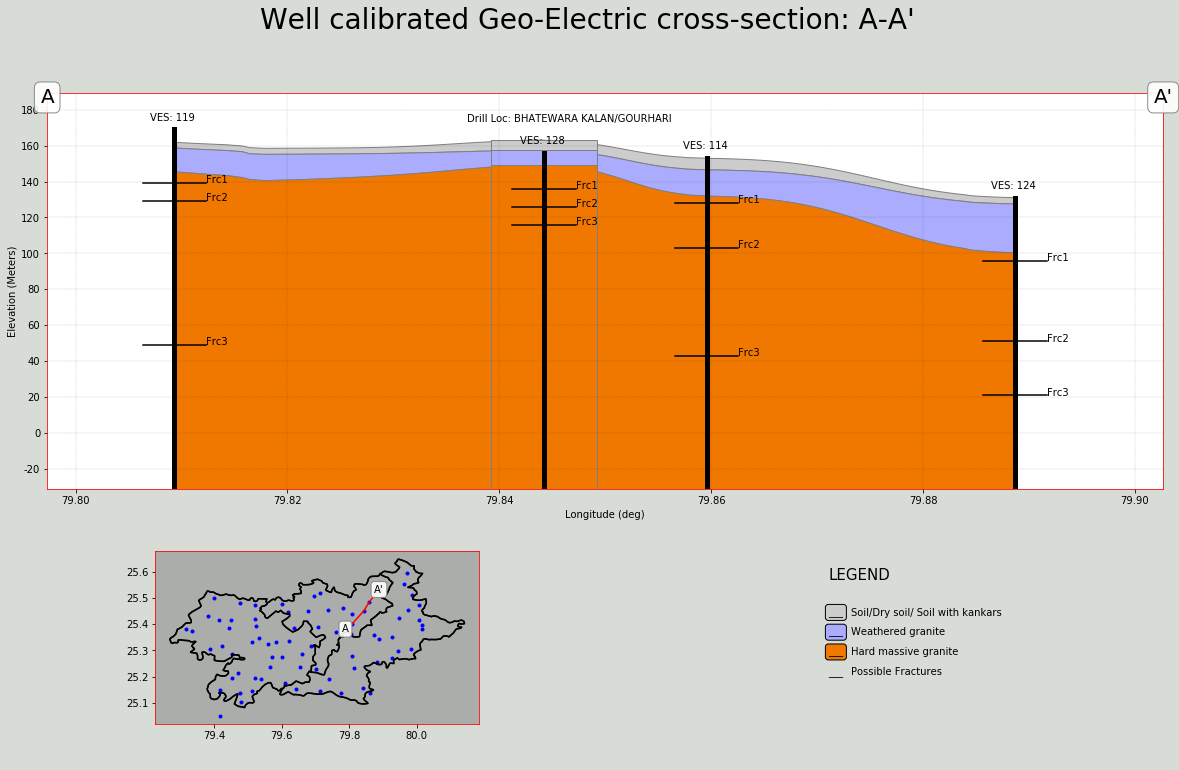

['260', '240', '220', '200', '180', '160', '140', '120', '100', '80', '60']


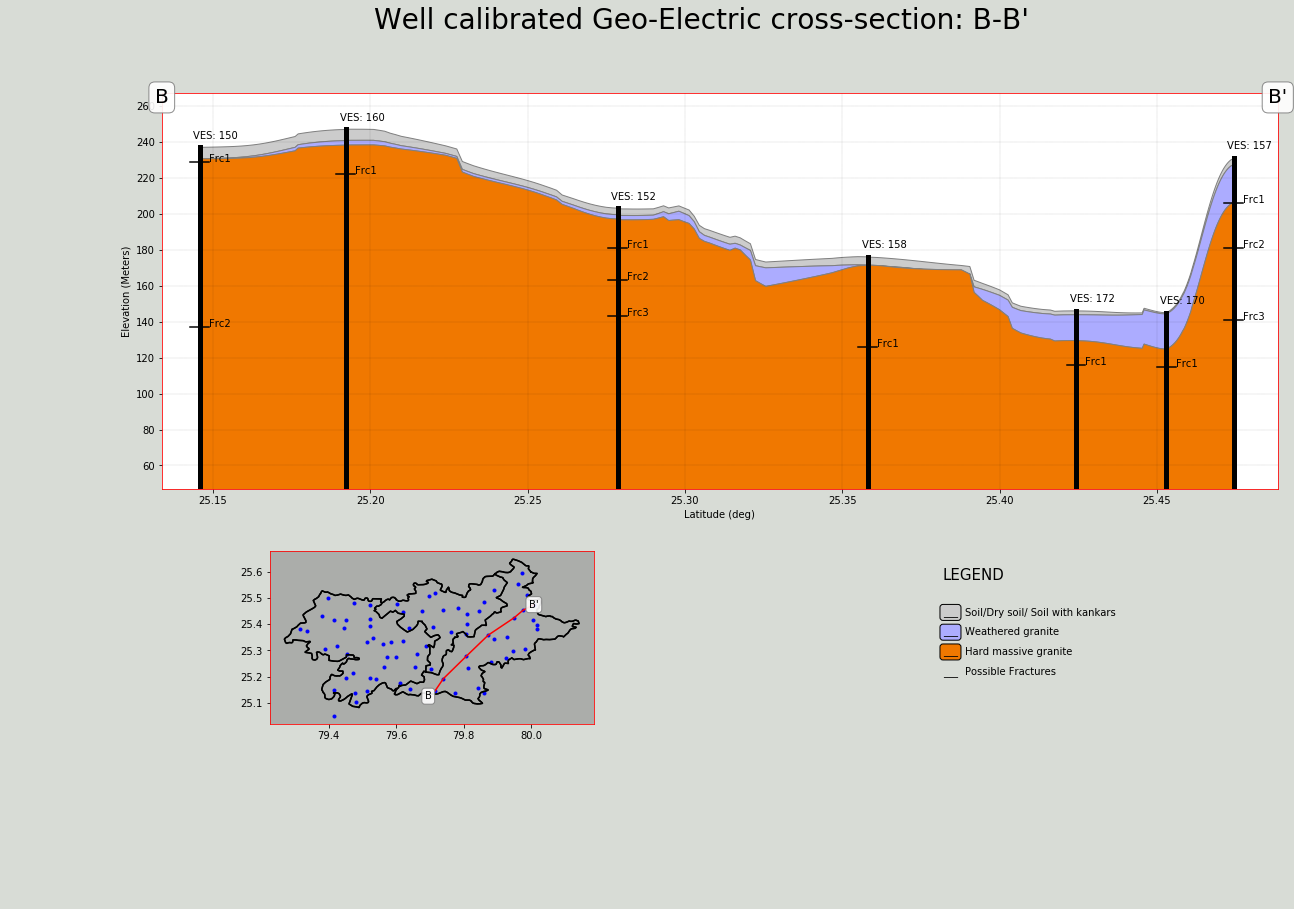

['260', '240', '220', '200', '180', '160', '140', '120', '100', '80', '60', '40']


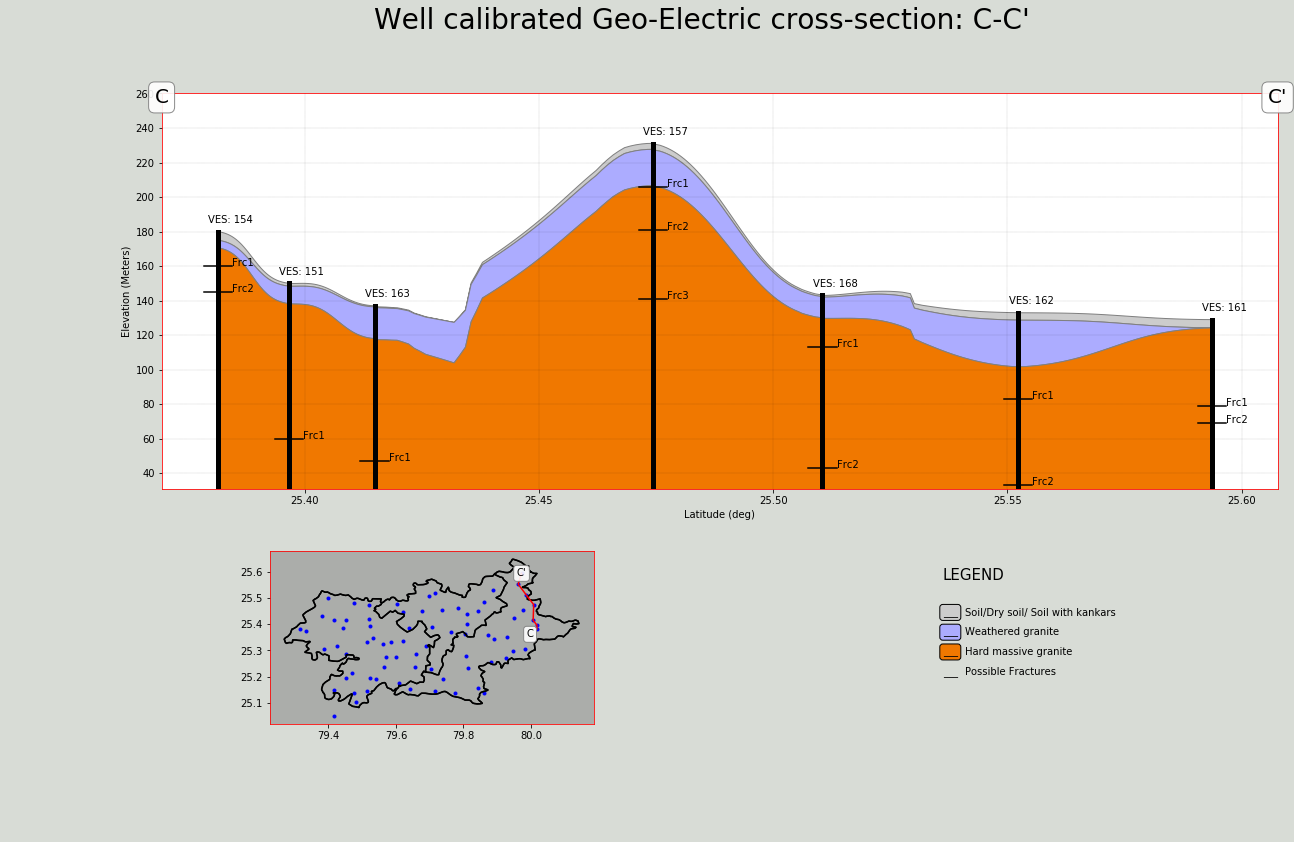

['260', '240', '220', '200', '180', '160', '140', '120', '100', '80', '60', '40']


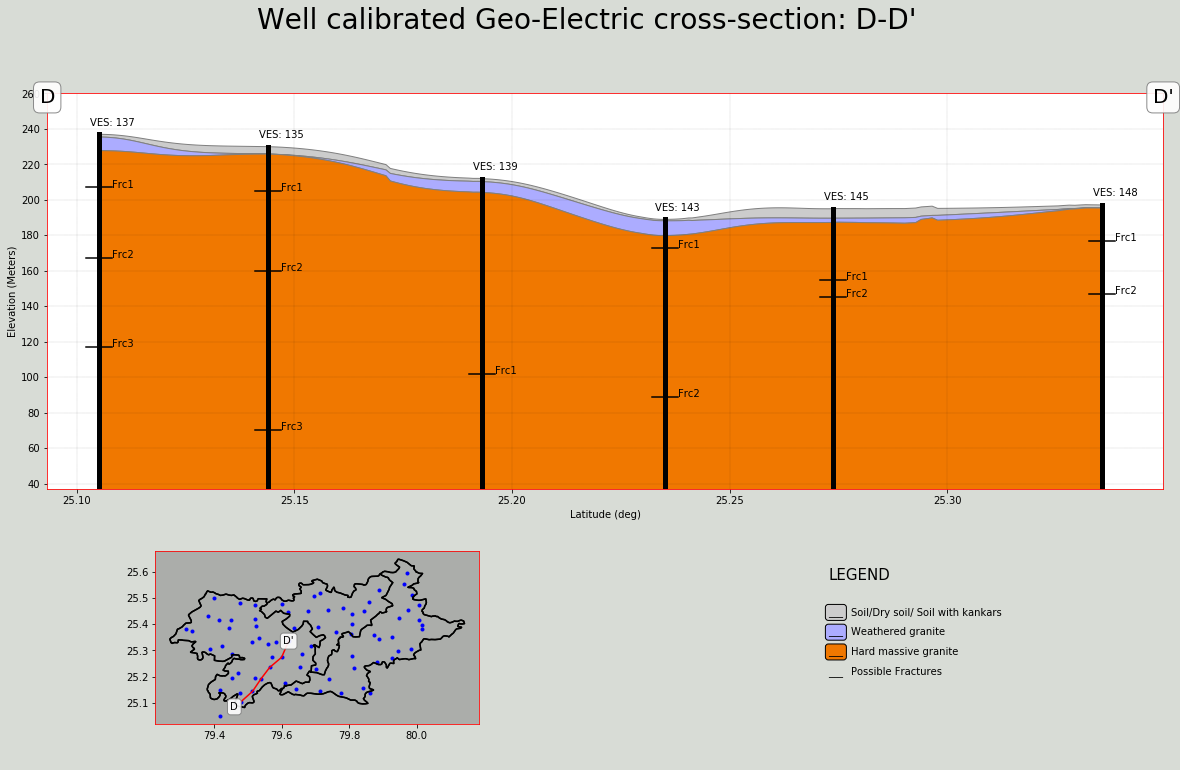

['200', '180', '160', '140', '120', '100', '80', '60', '40', '20', '0', '-20']


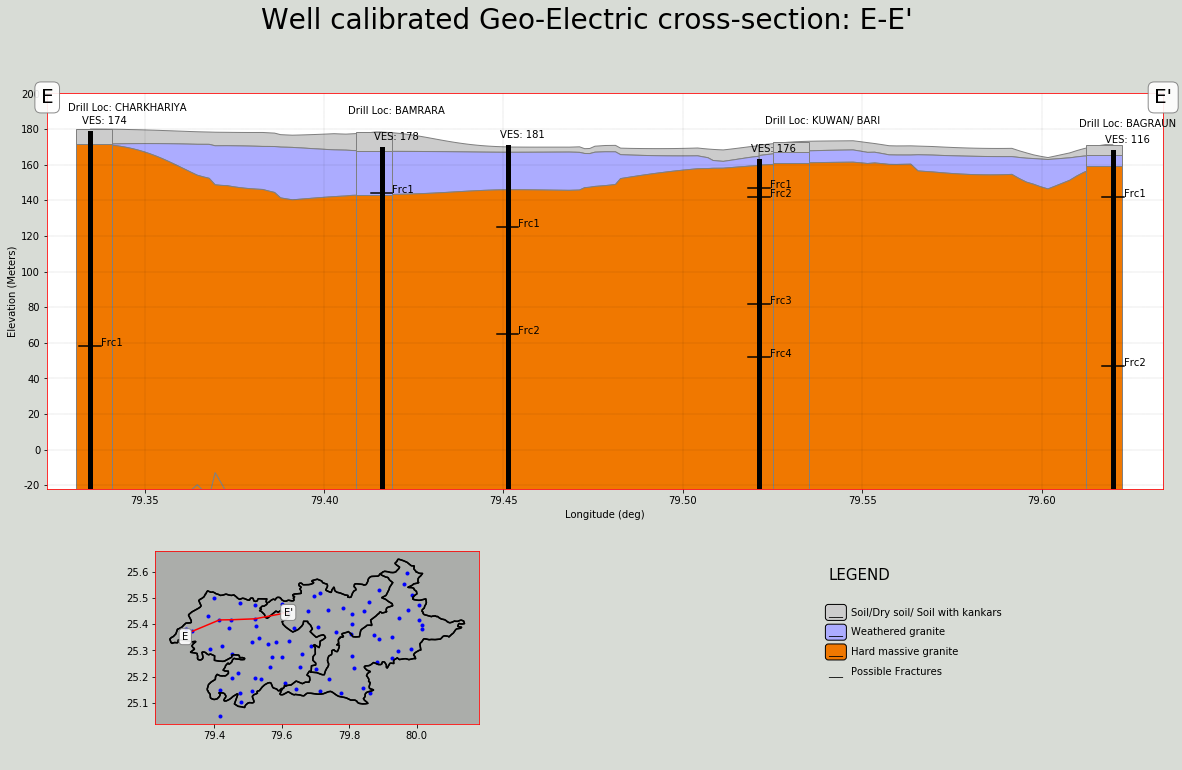

['200', '180', '160', '140', '120', '100', '80', '60', '40', '20', '0', '-20']


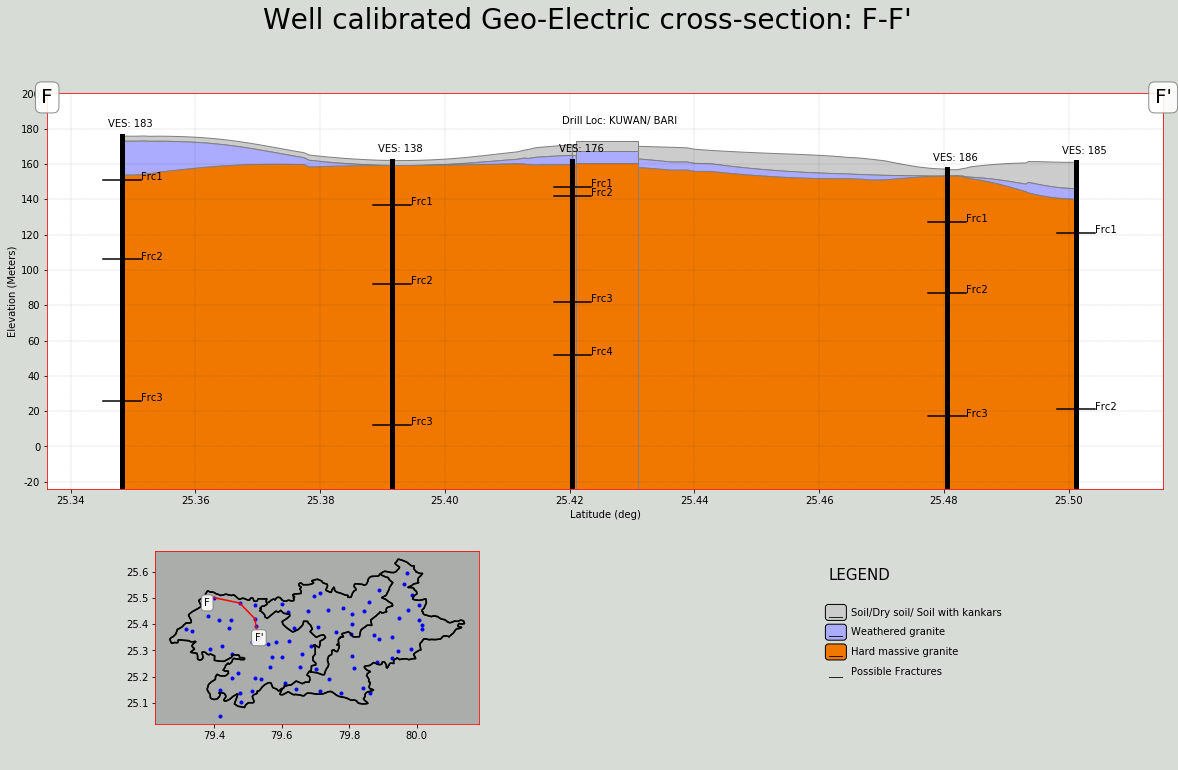

['240', '220', '200', '180', '160', '140', '120', '100', '80', '60', '40', '20']


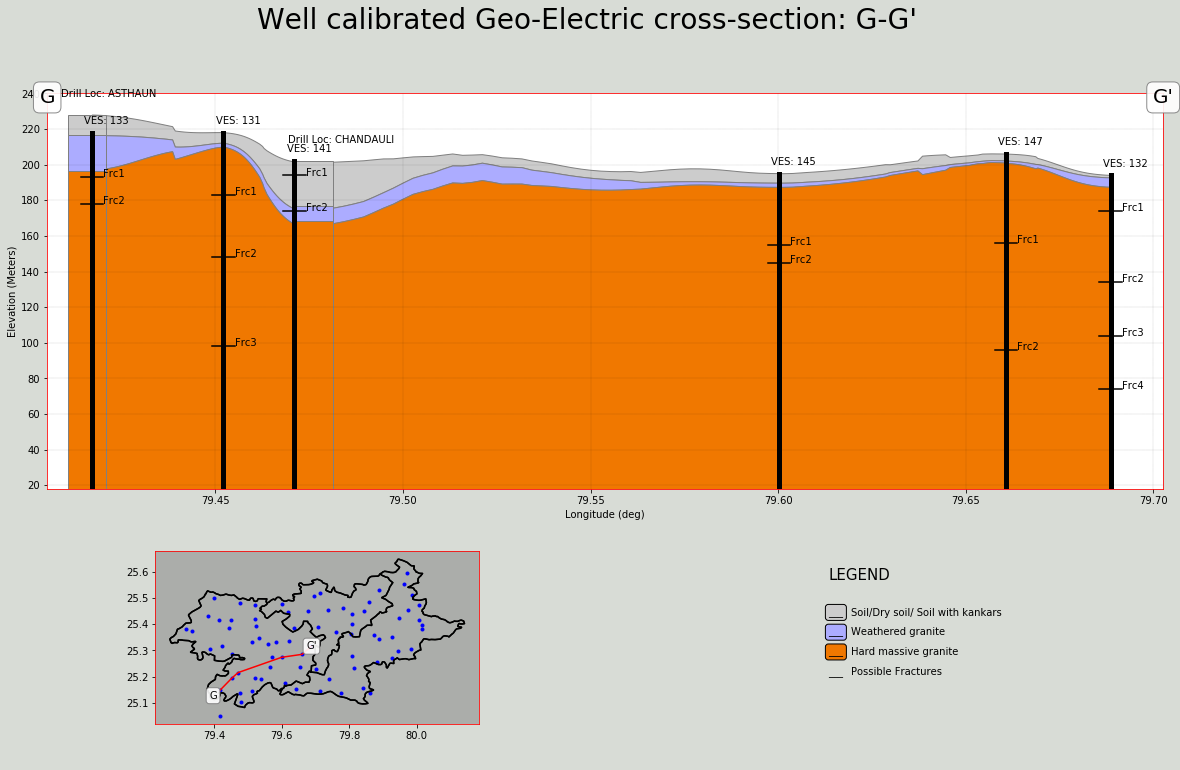

['180', '160', '140', '120', '100', '80', '60', '40', '20', '0', '-20']


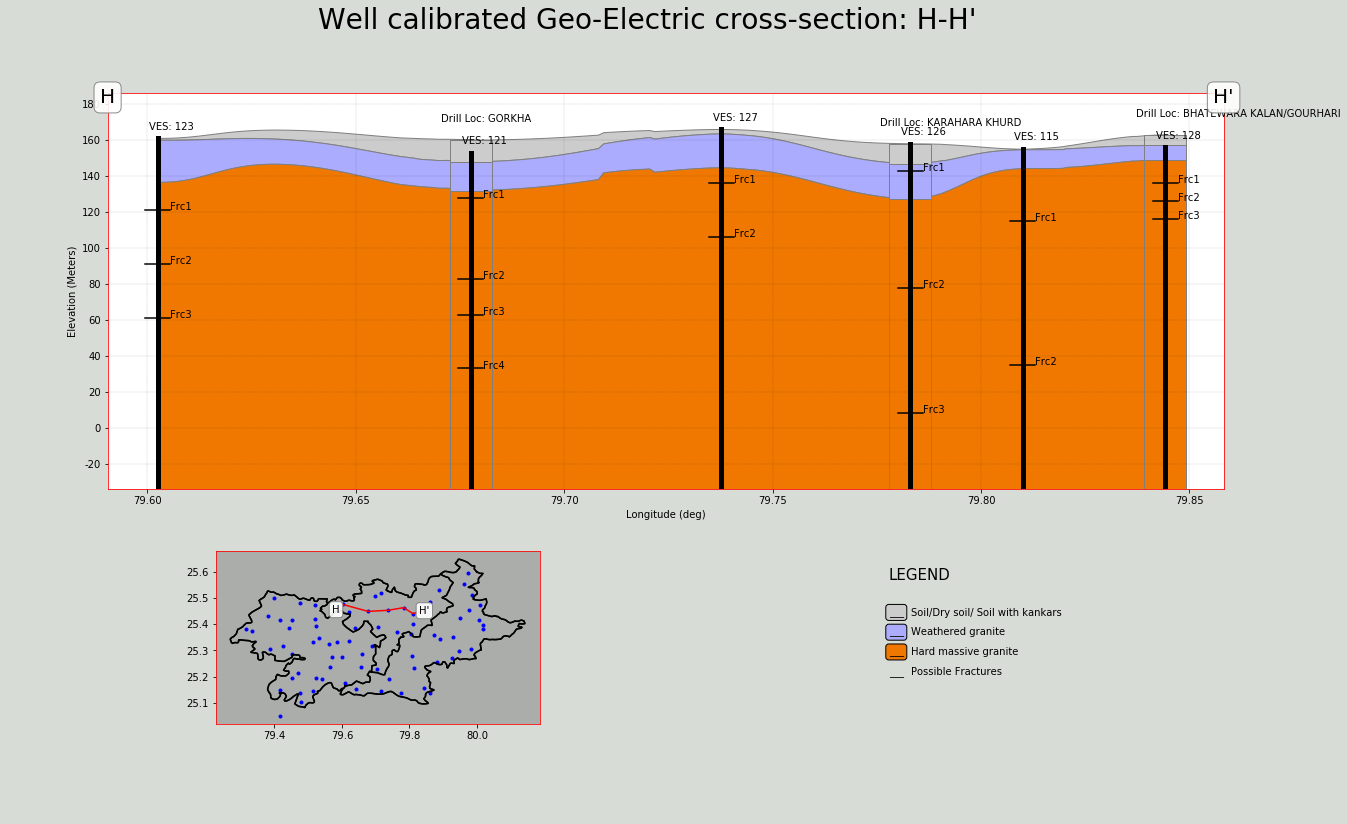

['220', '200', '180', '160', '140', '120', '100', '80', '60', '40', '20', '0']


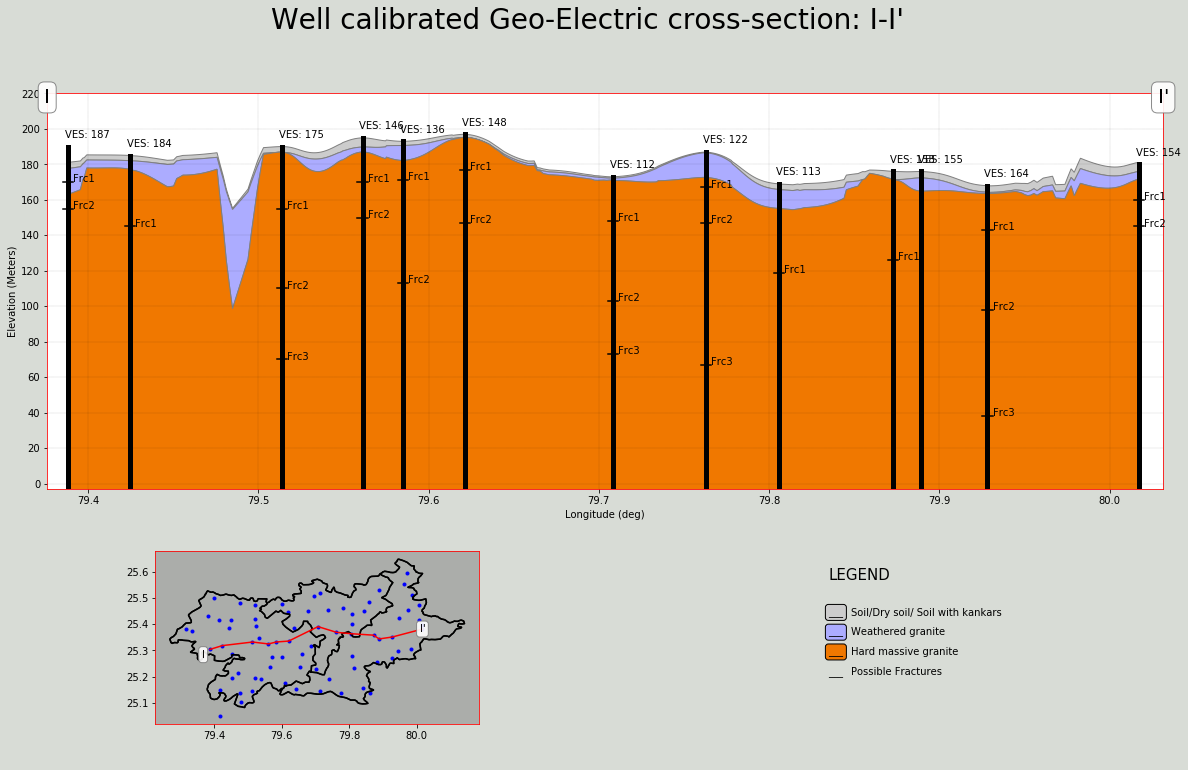

['260', '240', '220', '200', '180', '160', '140', '120', '100', '80', '60', '40']


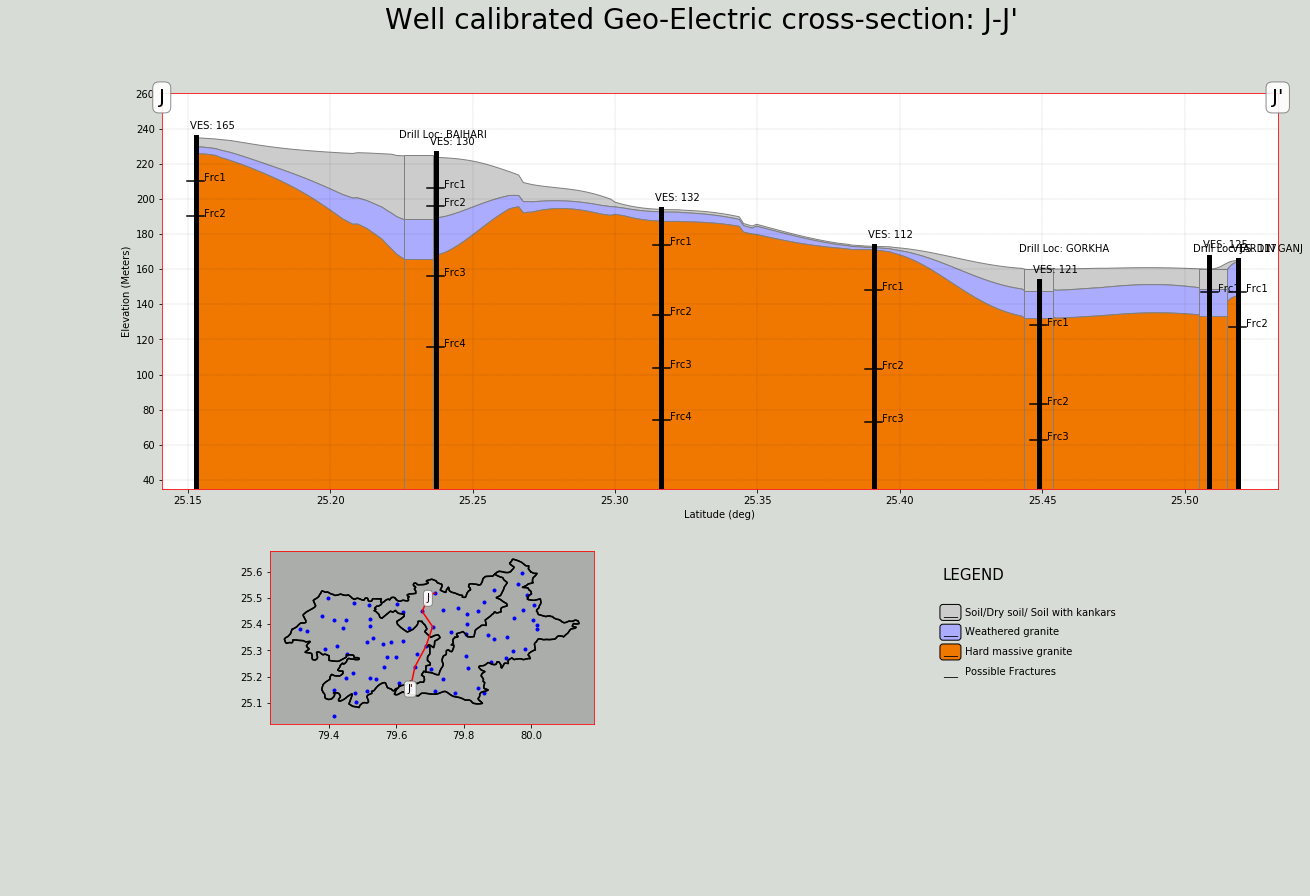

In [522]:
import itertools



fdf=pd.read_csv(base_folder+'ves fractures.csv')

#merge frac columns and make single frac column
lables=fdf.columns
fracdf=fdf[[lables[0],lables[1],lables[2],lables[3]]].copy() 
for l in lables[4:]:
    fracdf=fracdf.append(pd.DataFrame(fdf[[lables[0],lables[1],lables[2],l]].values,columns=fracdf.columns))
    
proj=[1,0,0,0,1,0,1,1,1,0]
sec_no=2
for sec_no in range(len(proj)):
#     f,ax=plt.subplots(figsize=(20, 8))
    f, (ax, ax2) = plt.subplots(2, 1, figsize=(20, 12),gridspec_kw = {'height_ratios':[6, 3]})
    f.patch.set_facecolor('xkcd:light gray')
    ax,crooked_line=plot_crosssection(ax,ax2,sections[sec_no],profile_name[sec_no],
                                      vesdf,final_depths,dvesdf,dfinal_depths,normal_proj=proj[sec_no],iwd_power=2)
    plot_location_map(plt,crooked_line,profile_name[sec_no])
    plt.rcParams["axes.edgecolor"] = "red"
    sec_name=profile_name[sec_no].upper()+'-'+profile_name[sec_no].upper()+'\''
    plt.suptitle("Well calibrated Geo-Electric cross-section: {}".format(sec_name),fontsize=28)
    plt.show()
    f.savefig(base_folder+'cross-sections//wc_'+profile_name[sec_no]+'_'+'_'.join(sections[sec_no])+'.png',dpi=300)
#     break
    # crooked_line
#     sections[0]

In [424]:
fracs[:,2]
print(vesdf.Block.unique())

['CHARKHARI' 'PANWARI' 'Charkhari' 'JAITPUR' 'Jaitpur' 'KABRAI']


In [426]:
a=np.array([2,5,3,4,1])
b=np.argsort(a)
a[b]

array([1, 2, 3, 4, 5])

In [430]:
# 20*round(211/20), np.mod(229,20)
# section
# width=0.1
# for s in section:
    
#     print(fracdf[fracdf['VES NO']==float(s)][fracdf.columns[1:]].values)
#     fracs=fracdf[fracdf['VES NO']==float(s)][fracdf.columns[1:]].values
# #     fracs[:,:2]-width/2;fracs[:,:2]+width/2
#     xyind=0
#     xarray=[fracs[0,xyind]-width/2, fracs[0,xyind]+width/2]
#     for f in fracs[:,2]:
#         ax.plot(xarray,[f,f],'k')
#     yarray
#     print(newarray)
#     break

In [13]:
vesdf[['VES No.','RL']],dvesdf[ ['Location','RL']]
# dvesdf
sec_no=0
section=sections[sec_no]
# get_drill_loc_polys(section,vesdf,dvesdf,dfinal_depths):
loc_coords=[]
for loc in section:
    loc_coords.append(vesdf[vesdf['VES No.']==str(loc)][['Easting','Northing','RL']].values.astype(float))
sec_coords=np.array( loc_coords)
sec_coords.shape=sec_coords.shape[0],sec_coords.shape[-1]
#     plt.plot(sec_coords[:,0],sec_coords[:,1])

dE,dN,dEle=dvesdf.Easting.values.astype(np.float),dvesdf.Northing.values.astype(np.float),dvesdf.RL.values.astype(np.float)
dlocs=dvesdf.Location.values
#     plt.plot(dE,dN,'.r')
dcoords=[[e,n] for e,n in zip(dE,dN)]

didxs=find_closeDlocsIdx(sec_coords[:,:2],dcoords,dist_thresh=2)  
# print('{} RL: {}'.format(dvesdf.iloc[didxs][['Location','RL']].values[0]))
print(dvesdf.iloc[didxs][['Easting','Northing','Location','RL']].values),loc_coords

[[79.8442 25.45128 'BAMHORI KALAN' 163.0]]


(None,
 [array([[  79.80932,   25.40122,  169.     ]]),
  array([[  79.8442 ,   25.45128,  156.     ]]),
  array([[  79.85957,   25.48371,  153.     ]]),
  array([[  79.88867,   25.53184,  131.     ]])])

In [219]:
crooked_line[:,0]
# for polyset in polysets:
#     for section in polyset:
#         xycoords=section[0]        
#         plt.plot(xycoords[:,0],xycoords[:,1],'*k')

array([ 79.71526,  79.73988,  79.80843,  79.87275,  79.94946,  79.97585,
        80.00813])

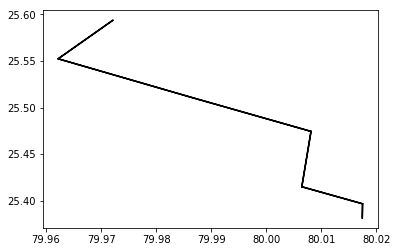

In [72]:
# for xyzcoord in np.array(xyzcoords):
# #     xycoords=section[0]        
#     plt.plot(xyzcoord[:,1],xyzcoord[:,2],'k')
# plt.ylim(-270,70)
# plt.gca().invert_yaxis()


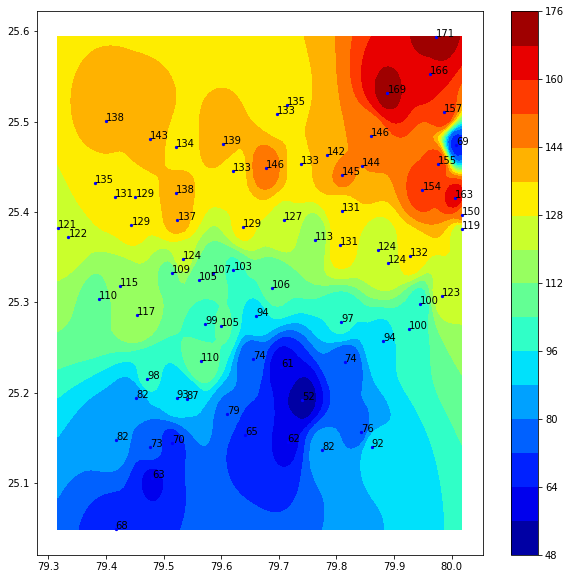

In [101]:
P=xy_final_depths[:,[0,1,-1]]
calc_plot_grid(P,gridsize=(100,100),method='iwd',power=4)

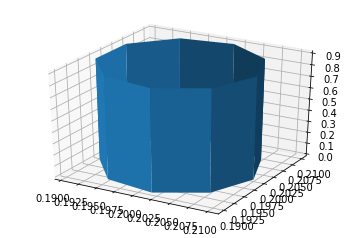

In [4]:
import numpy as np

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 2)
    theta = np.linspace(0, 2*np.pi, 10)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.01,0.9)
ax.plot_surface(Xc, Yc, Zc, alpha=1)

plt.show()

In [5]:
data_for_cylinder_along_z(0.2,0.2,0.01,0.9)
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

N = 50
trace1 = go.Mesh3d(x=(30*np.random.randn(N)),
                   y=(25*np.random.randn(N)),
                   z=(30*np.random.randn(N)),
                   opacity=0.5,)


layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="rgb(255, 255, 255)",
                         showbackground=True,
                         zerolinecolor="rgb(255, 255, 255)",),
                    yaxis = dict(
                        backgroundcolor="rgb(230, 200,230)",
                        gridcolor="rgb(255, 255, 255)",
                        showbackground=True,
                        zerolinecolor="rgb(255, 255, 255)"),
                    zaxis = dict(
                        backgroundcolor="rgb(230, 230,200)",
                        gridcolor="rgb(255, 255, 255)",
                        showbackground=True,
                        zerolinecolor="rgb(255, 255, 255)",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )
fig = go.Figure(data=[trace1], layout=layout)
py.iplot(fig)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.